## Burning Area Monitoring

The wildfire that swept through Athens and Mati in the summer of 2018 left a profound impact on both the environment and local communities. In response to such disasters, satellite imagery has proven invaluable for assessing and monitoring the extent of fire damage. One crucial tool in this assessment is the differenced Normalized Burn Ratio (dNBR), derived from Sentinel-2 satellite data. dNBR compares pre- and post-fire conditions by subtracting the pre-fire NBR from the post-fire NBR, highlighting areas of significant burn severity where vegetation and surface conditions have been altered.

The application of dNBR allows for detailed mapping of burn severity, providing insights into the intensity of fire impacts across the affected landscape. By leveraging Sentinel-2's high spatial resolution and multispectral capabilities, analysts can identify and prioritize areas for intervention and rehabilitation efforts. This notebook explores how dNBR analysis was utilized to assess the Athens-Mati fire of 2018, showcasing its utility in environmental monitoring, disaster response, and land management strategies.

### The NBR index

NBR stands for Normalized Burn Ratio. It is a spectral index commonly used in remote sensing and satellite imagery analysis, particularly for assessing fire damage and burn severity in natural landscapes. The NBR index is calculated using near-infrared (NIR) and shortwave infrared (SWIR) bands of satellite imagery.

The formula for NBR is:

$$
\begin{aligned}
\text{NBR} & = \frac{(\text{NIR} - \text{SWIR})}{(\text{NIR} + \text{SWIR})} \\
\end{aligned}
$$

The NBR index is particularly useful for assessing the severity of burn scars and fire-affected areas in vegetation. It works on the principle that burned areas exhibit different reflectance properties in NIR and SWIR bands compared to unburned or healthy vegetation:

<b>Positive Values:</b> Typically represent healthy vegetation.

<b>Negative Values:</b> Indicate areas affected by fire, with more negative values indicating greater burn severity.

### Load Required Libraries

In [34]:
import pyproj
import pystac_client

from shapely.geometry import box
from shapely.ops import transform

import odc.stac
from odc.geo.geobox import GeoBox
import matplotlib.colors as mcolors

from geogif import dgif
from dea_tools.plotting import rgb

In [35]:
def calculate_index(data, index):

    """
    Optical Indices Computation

    :param xarray: datacube_object
    :param string: you want to compute
    
    """
    if index.lower() == 'cri2':
        B02 = data.B02.astype('float16')
        B05 = data.B05.astype('float16')
        return (1/B02)-(1/B05)
    if index.lower() == 'ndvi':
        B08 = data.B08.astype('float16')
        B04 = data.B04.astype('float16')
        return (B08-B04)/(B08+B04)
    if index.lower() == 'ndwi':
        B08 = data.B08.astype('float16')
        B03 = data.B03.astype('float16')
        return (B03-B08)/(B08+B03)
    if index.lower() == 'ndmi':
        B08 = data.B08.astype('float16')
        B11 = data.B11.astype('float16')
        return (B08-B11)/(B08+B11)
    if index.lower() == 'psri':
        B02 = data.B02.astype('float16')
        B04 = data.B04.astype('float16')
        B06 = data.B06.astype('float16')
        return (B04-B02)/ B06
    if index.lower() == 'savi':
        L = 0.428
        B08 = data.B08.astype('float16')
        B04 = data.B04.astype('float16')
        return ((B08 - B04)/(B08 + B04 + L))*(1.0 + L)
    if index.lower() == 'evi':
        B08 = data.B08.astype('float16')
        B04 = data.B04.astype('float16')
        return 2.5*(B08-B04)/((B08+6*B04-7.5*B02) + 1.0)
    if index.lower() == 'nbr':
        B12 = data.B12.astype('float16')
        B08 = data.B08.astype('float16')
        return (B08-B12)/(B08+B12)
    if index.lower() == 'visual':
        B02 = data.B02.astype('float16')
        B03 = data.B03.astype('float16')
        B04 = data.B04.astype('float16')
        return B02 + B03 + B04
    if index.lower() == 'bi':
        B02 = data.B02.astype('float16')
        B04 = data.B04.astype('float16')
        B08 = data.B08.astype('float16')
        B11 = data.B11.astype('float16')
        return ((B11+B04) - (B08+B02)) / ((B11+B04) + (B08+B02))

In [36]:
def digitize_date(month,day):    
    if month<10:
        month=f"0{month}"

    if day<10:
        day=f"0{day}"

    return month,day

STAC_URL = "https://earth-search.aws.element84.com/v0"
# STAC connection information for Sentinel 2 COGs
# v0 collection
STAC_COLLECTION = "sentinel-s2-l2a-cogs"
# v1 collection 
# STAC_COLLECTION = "sentinel-2-l2a"


# spatial projection information
CRS_STRING = "9705"
EPSG = pyproj.CRS.from_string(CRS_STRING).to_epsg()

aoi = (23.906250,38.000356,24.004786,38.062149)
aoi_box = box(*aoi)

# BANDS = ["B04", "B03", "B02", "B05","B06","B08","B11","B12","SCL"]
# BANDS = ["red", "green", "blue"]
START_DATE = "2018-06-01"
END_DATE = "2018-08-31"

# STAC items store bounding box info in epsg:4326
transformer_4326 = pyproj.Transformer.from_crs(
    crs_from=CRS_STRING,
    crs_to="epsg:4326",
    always_xy=True,
)
bbox_4326 = transform(transformer_4326.transform, aoi_box).bounds

catalog = pystac_client.Client.open(STAC_URL)
catalog.add_conforms_to("ITEM_SEARCH")
catalog.add_conforms_to("QUERY")

stac_items = catalog.search(
    collections=[STAC_COLLECTION],
    bbox=bbox_4326,
    datetime=[START_DATE, END_DATE],
    query={"eo:cloud_cover": {"lt": 10}}
)

# dx = 3/3600  # ~90m resolution
dx = 10 / 111320 # ~10m res
epsg = 4326
geobox = GeoBox.from_bbox(aoi, crs=f"epsg:{epsg}", resolution=dx)

# using Open Data Cube stac component
data = odc.stac.load(
    stac_items.items(),
    chunks={},
    geobox=geobox,
    bands=["B12","B08", "B02", "B03", "B04", "B11"],
    resampling="bilinear",
    groupby="solar_day" # delete duplicates due to satellite overlap
)


In [37]:
data

<xarray.Dataset> Size: 218MB
Dimensions:      (latitude: 689, longitude: 1098, time: 12)
Coordinates:
  * latitude     (latitude) float64 6kB 38.06 38.06 38.06 ... 38.0 38.0 38.0
  * longitude    (longitude) float64 9kB 23.91 23.91 23.91 ... 24.0 24.0 24.0
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 96B 2018-06-05T09:17:09 ... 2018-08-29...
Data variables:
    B12          (time, latitude, longitude) float32 36MB dask.array<chunksize=(1, 689, 1098), meta=np.ndarray>
    B08          (time, latitude, longitude) float32 36MB dask.array<chunksize=(1, 689, 1098), meta=np.ndarray>
    B02          (time, latitude, longitude) float32 36MB dask.array<chunksize=(1, 689, 1098), meta=np.ndarray>
    B03          (time, latitude, longitude) float32 36MB dask.array<chunksize=(1, 689, 1098), meta=np.ndarray>
    B04          (time, latitude, longitude) float32 36MB dask.array<chunksize=(1, 689, 1098), meta=np.ndarray>
    B11          (time, latitude, longitude) float32 36MB dask.array<chunksize=(1, 689, 1098), meta=np.ndarray>

In [38]:
data['nbr'] = calculate_index(data,'nbr')

In [39]:
data

<xarray.Dataset> Size: 236MB
Dimensions:      (latitude: 689, longitude: 1098, time: 12)
Coordinates:
  * latitude     (latitude) float64 6kB 38.06 38.06 38.06 ... 38.0 38.0 38.0
  * longitude    (longitude) float64 9kB 23.91 23.91 23.91 ... 24.0 24.0 24.0
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 96B 2018-06-05T09:17:09 ... 2018-08-29...
Data variables:
    B12          (time, latitude, longitude) float32 36MB dask.array<chunksize=(1, 689, 1098), meta=np.ndarray>
    B08          (time, latitude, longitude) float32 36MB dask.array<chunksize=(1, 689, 1098), meta=np.ndarray>
    B02          (time, latitude, longitude) float32 36MB dask.array<chunksize=(1, 689, 1098), meta=np.ndarray>
    B03          (time, latitude, longitude) float32 36MB dask.array<chunksize=(1, 689, 1098), meta=np.ndarray>
    B04          (time, latitude, longitude) float32 36MB dask.array<chunksize=(1, 689, 1098), meta=np.ndarray>
    B11          (time, latitude, longitude) float32 36MB dask.array<chunksize=(1, 689, 1098), meta=np.ndarray>
    nbr          (time, latitude, longitude) float16 18MB dask.array<chunksize=(1, 689, 1098), meta=np.ndarray>

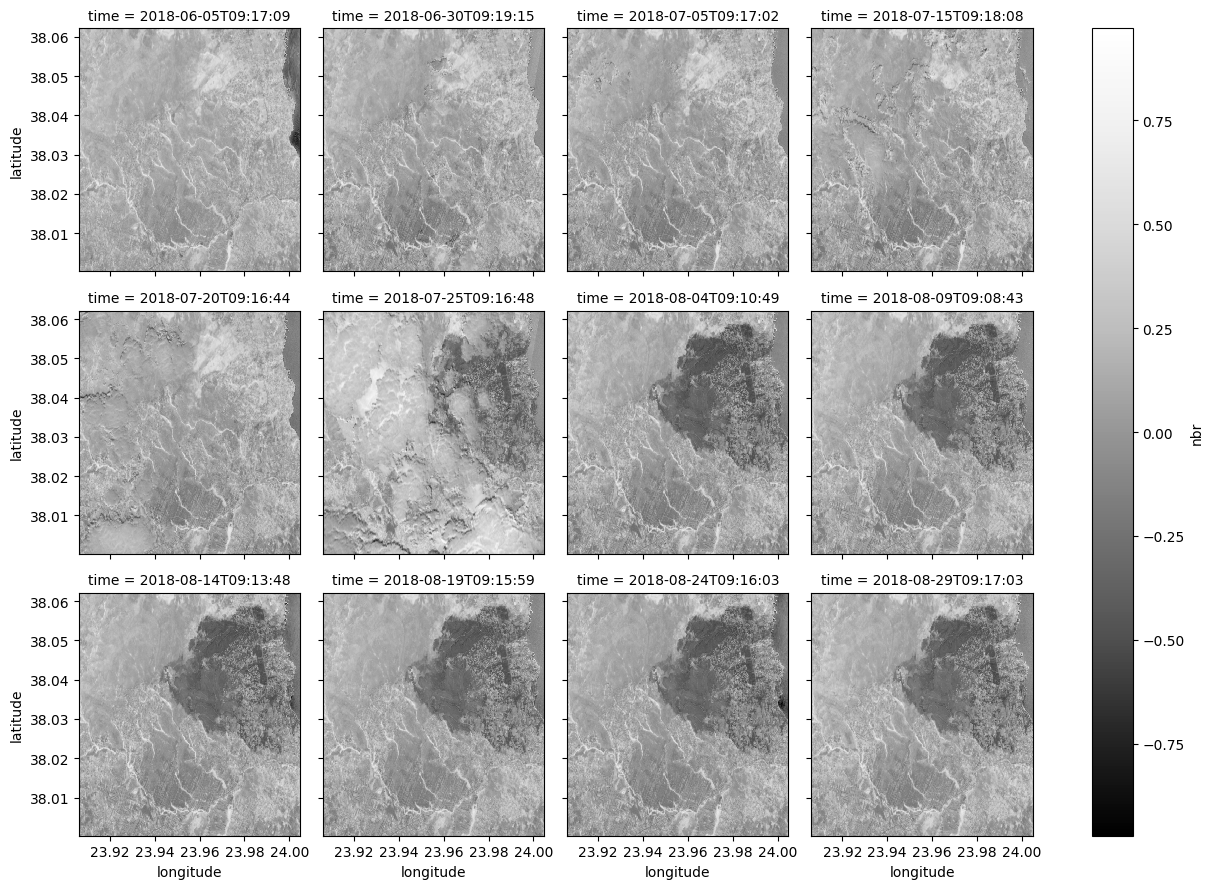

In [40]:
data.nbr.plot(col='time',cmap="Greys_r",col_wrap=4)

In [41]:
dNBR = data['nbr'].diff(dim='time')

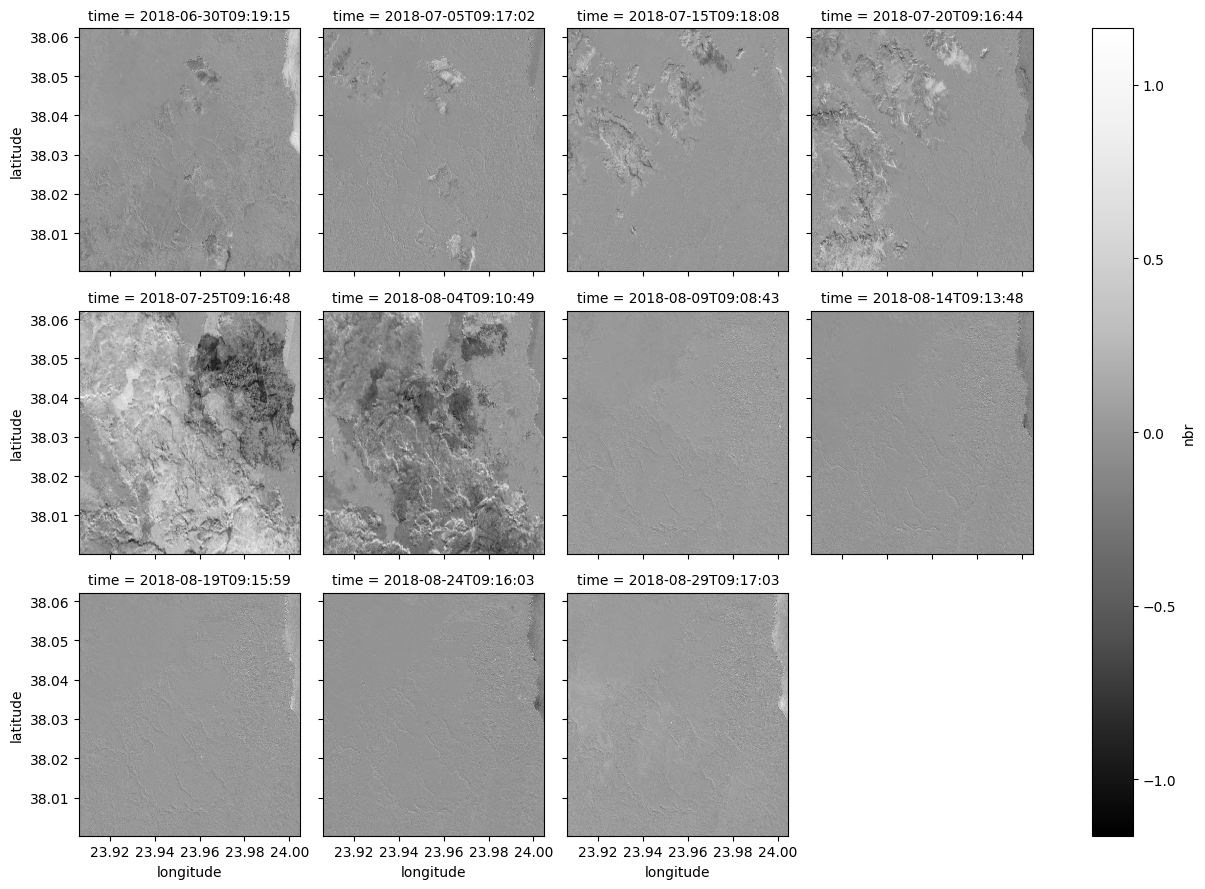

In [42]:
dNBR.plot(col='time',cmap="Greys_r",col_wrap=4)

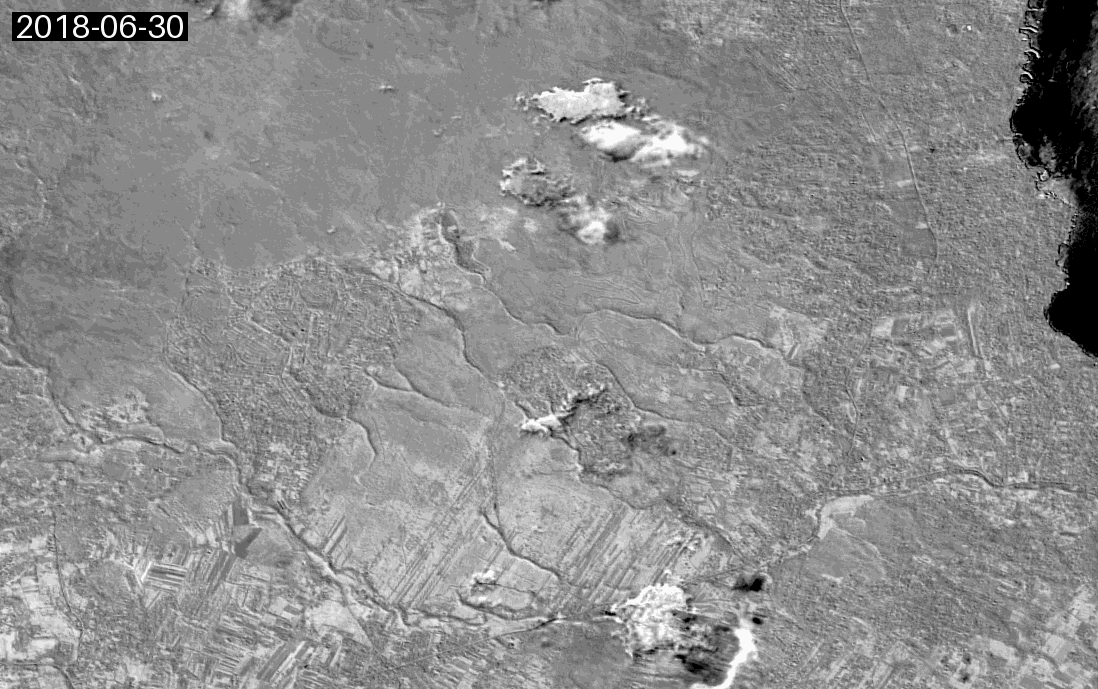

In [43]:
dgif(arr=dNBR,cmap="Greys",fps=2).compute()

Now, let's choose and calculate another index:

**Bare soil index** (https://github.com/awesome-spectral-indices/awesome-spectral-indices/blob/main/output/spectral-indices-table.csv)


$$
\begin{aligned}
\text{BI} & = \frac{(\text{S1} + \text{R}) - (\text{N} + \text{B})}{(\text{S1} + \text{R}) + (\text{N} + \text{B})} \\
\end{aligned}
$$

<center>

|Band standard name | Description | Spectral Range (nm) | S2 Band name |
|----|----|----|----|
|S1 | SWIR | 1550 - 1750 | B11|
|R  | Red | 620 - 690 | B4|
|N  | NIR | 760 - 900 | B8|
|B  | Blue | 450 - 530 | B2|

</center>

In [44]:
data['bi'] = calculate_index(data,'bi')

In [45]:
data

<xarray.Dataset> Size: 254MB
Dimensions:      (latitude: 689, longitude: 1098, time: 12)
Coordinates:
  * latitude     (latitude) float64 6kB 38.06 38.06 38.06 ... 38.0 38.0 38.0
  * longitude    (longitude) float64 9kB 23.91 23.91 23.91 ... 24.0 24.0 24.0
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 96B 2018-06-05T09:17:09 ... 2018-08-29...
Data variables:
    B12          (time, latitude, longitude) float32 36MB dask.array<chunksize=(1, 689, 1098), meta=np.ndarray>
    B08          (time, latitude, longitude) float32 36MB dask.array<chunksize=(1, 689, 1098), meta=np.ndarray>
    B02          (time, latitude, longitude) float32 36MB dask.array<chunksize=(1, 689, 1098), meta=np.ndarray>
    B03          (time, latitude, longitude) float32 36MB dask.array<chunksize=(1, 689, 1098), meta=np.ndarray>
    B04          (time, latitude, longitude) float32 36MB dask.array<chunksize=(1, 689, 1098), meta=np.ndarray>
    B11          (time, latitude, longitude) float32 36MB dask.array<chunksize=(1, 689, 1098), meta=np.ndarray>
    nbr          (time, latitude, longitude) float16 18MB dask.array<chunksize=(1, 689, 1098), meta=np.ndarray>
    bi           (time, latitude, longitude) float16 18MB dask.array<chunksize=(1, 689, 1098), meta=np.ndarray>

In [46]:
# It would be nice to represent bare soil (+1) as red and no bare soil as green
# Like so, we create a custom color for properly visualizing the index.
cmap = mcolors.LinearSegmentedColormap.from_list('green_red', [(0, 'green'), (0.5, 'white'), (1, 'red')])

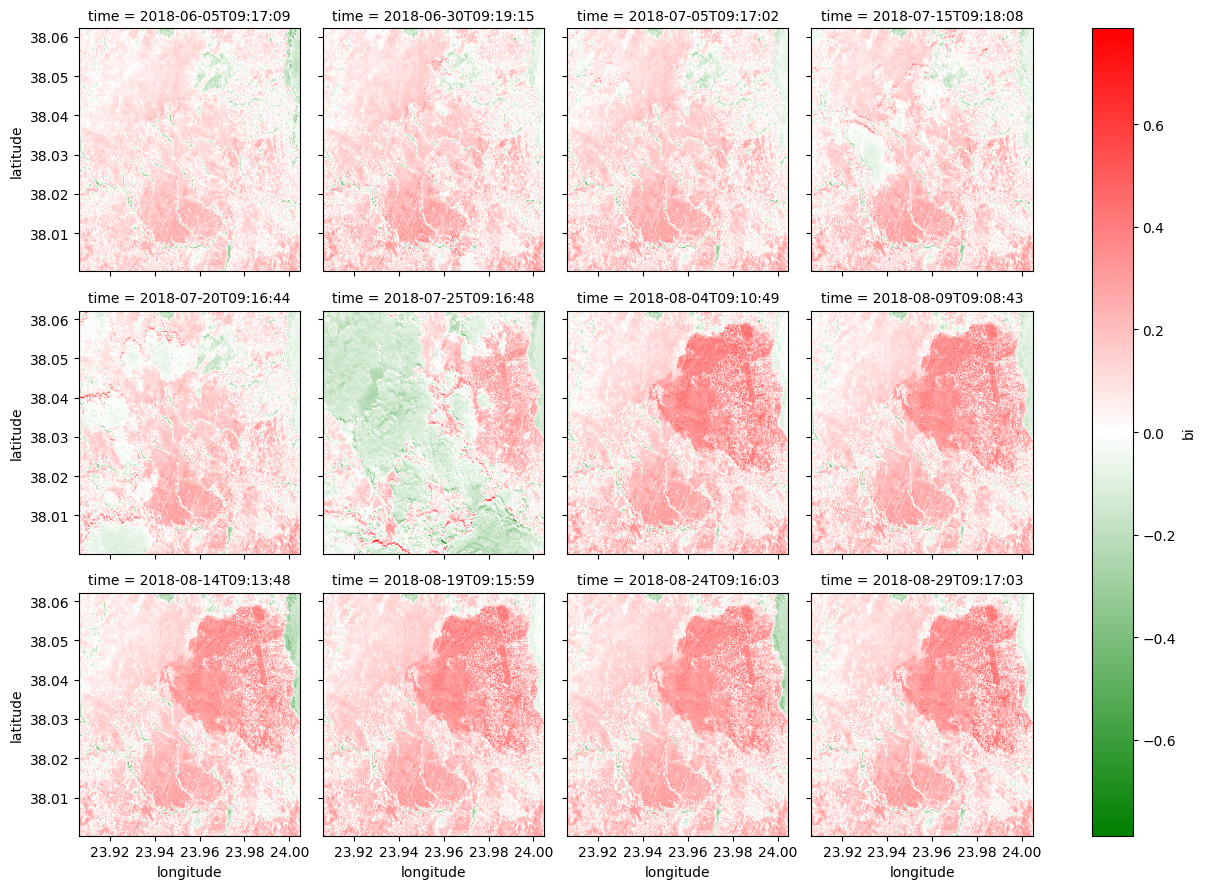

In [47]:
data.bi.plot(col='time',cmap=cmap,col_wrap=4)

As you can see, especially at the top right region of the area, the green spots before the fire indicate no-bare soil, while after the fire, the area changed totally.
Let's see what was there before:

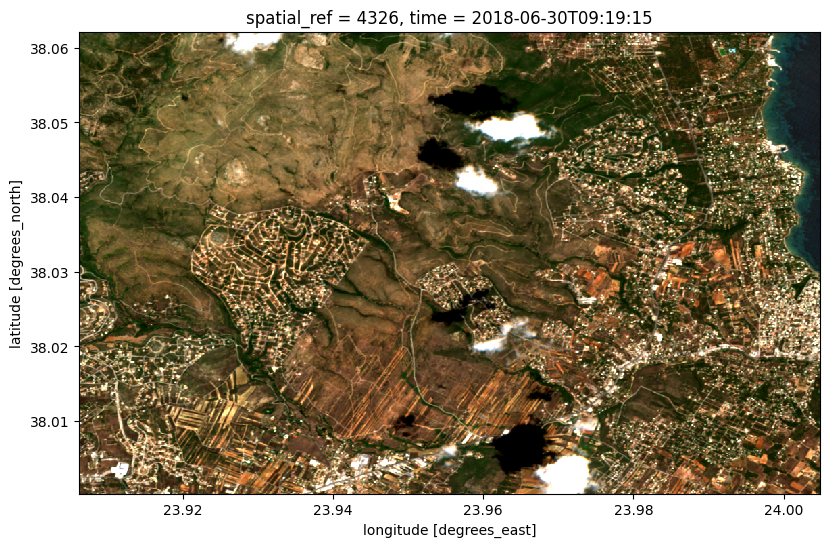

In [49]:
rgb(data, bands=["B04", "B03", "B02"], index=1)

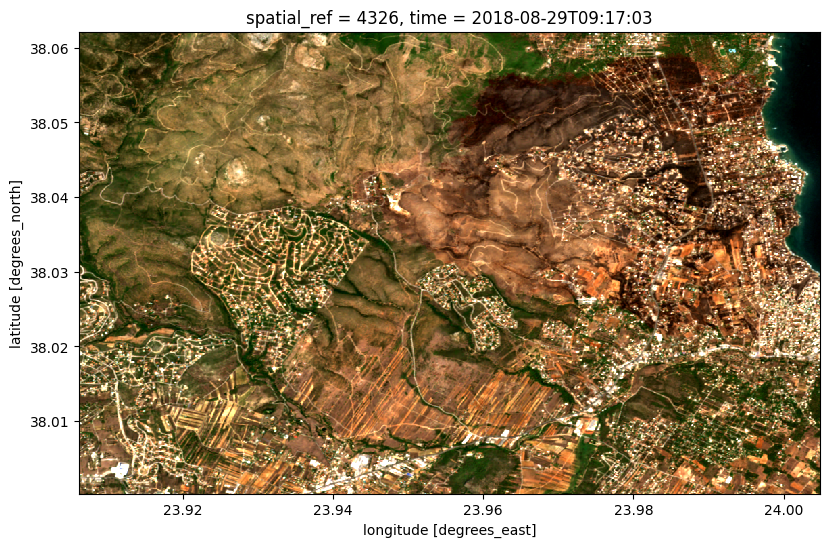

In [ ]:
rgb(data, bands=["B04", "B03", "B02"], index=11)